## Hypothesis validation notebook (MNIST)

**Hypothesis (operational):** In representation space, clean samples exhibit class-conditional local regularity. Adversarial samples are enriched among points showing decision–geometry inconsistency (e.g., class-mixed neighborhoods; atypical for predicted class relative to alternatives).

Notes for local runtime:
- MNIST is larger; we cap PH scoring with `MAX_POINTS_FOR_SCORING`.
- `IMAGE` requires `torchvision` and (unless already present) an MNIST download.
- You can set `cfg.data.root` and `cfg.data.download=True` below.


In [7]:
import pathlib
import sys
import time
from dataclasses import replace

import numpy as np
import matplotlib.pyplot as plt

repo_root = pathlib.Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from src.api import (
    get_dataset,
    get_model,
    train,
    generate_adversarial,
    compute_scores,
    concat_scores,
    fit_detector,
)
from src.evaluation import evaluate_detector
from src.models import get_model_predictions, extract_features_batch
from src.utils import ExperimentConfig, DataConfig, ModelConfig, AttackConfig, GraphConfig, DetectorConfig
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA


### Config

You may need to set `download=True` if MNIST isn't present under `root`.


In [8]:
SEED = 42
MAX_POINTS_FOR_SCORING = 200

# Dataset reduction (set these to make MNIST faster/lighter)
# Default below is a "fast" setting: 10 classes, but fewer samples per split.
INCLUDE_CLASSES = [0, 1, 2]  # e.g. [0, 1, 2] or [3, 5]
RELABEL_CLASSES = True  # if True (and INCLUDE_CLASSES != None), map included classes -> 0..C-1

# Choose ONE of the following (or combine max + per-class cap):
TRAIN_MAX_N = None          # e.g. 8000
VAL_MAX_N = None            # e.g. 2000
TEST_MAX_N = None           # e.g. 2000

# Fast defaults (roughly: train=2000, val=500, test=1000 for MNIST)
TRAIN_PER_CLASS_N = 200
VAL_PER_CLASS_N = 50
TEST_PER_CLASS_N = 100

SUBSAMPLE_STRATIFIED = True # if using *_MAX_N, keep classes roughly balanced


def reduce_image_bundle(
    bundle,
    *,
    include_classes=None,
    relabel: bool = True,
    train_max_n=None,
    val_max_n=None,
    test_max_n=None,
    train_per_class_n=None,
    val_per_class_n=None,
    test_per_class_n=None,
    stratified: bool = True,
    seed: int = 0,
):
    """Filter + subsample an IMAGE bundle (e.g. MNIST) in-place and return it."""

    def _as_int_labels(y):
        return np.asarray(y, dtype=int)

    def _filter_classes(X, y, classes):
        if classes is None:
            return np.asarray(X), _as_int_labels(y)
        classes_arr = np.asarray(list(classes), dtype=int)
        keep = np.isin(_as_int_labels(y), classes_arr)
        return np.asarray(X)[keep], _as_int_labels(y)[keep]

    def _maybe_relabel(y, classes):
        if classes is None or not relabel:
            return _as_int_labels(y), None
        ordered = list(map(int, classes))
        ordered = sorted(set(ordered))
        mapping = {c: i for i, c in enumerate(ordered)}
        y_in = _as_int_labels(y)
        y_out = np.array([mapping[int(v)] for v in y_in], dtype=int)
        return y_out, mapping

    def _stratified_take(y, n_take, rng):
        y = _as_int_labels(y)
        classes = np.unique(y)
        if len(classes) == 0:
            return np.array([], dtype=int)
        base = int(n_take) // int(len(classes))
        rem = int(n_take) % int(len(classes))
        idx_all = []
        for i, c in enumerate(classes):
            c_idx = np.flatnonzero(y == c)
            want = base + (1 if i < rem else 0)
            want = min(len(c_idx), int(want))
            if want > 0:
                idx_all.append(rng.choice(c_idx, size=want, replace=False))
        if not idx_all:
            return np.array([], dtype=int)
        idx = np.concatenate(idx_all).astype(int)
        rng.shuffle(idx)
        return idx

    def _subsample(X, y, *, max_n=None, per_class_n=None, rng):
        X = np.asarray(X)
        y = _as_int_labels(y)
        n = len(y)
        if n == 0:
            return X, y

        idx = np.arange(n, dtype=int)

        if per_class_n is not None:
            take_idx = []
            for c in np.unique(y):
                c_idx = np.flatnonzero(y == c)
                want = min(len(c_idx), int(per_class_n))
                if want > 0:
                    take_idx.append(rng.choice(c_idx, size=want, replace=False))
            idx = np.concatenate(take_idx).astype(int) if take_idx else np.array([], dtype=int)
            rng.shuffle(idx)

        if max_n is not None and len(idx) > int(max_n):
            y_idx = y[idx]
            if stratified:
                keep_rel = _stratified_take(y_idx, int(max_n), rng)
                idx = idx[keep_rel]
            else:
                idx = rng.choice(idx, size=int(max_n), replace=False)

        return X[idx], y[idx]

    rng = np.random.default_rng(int(seed))

    # 1) class filter (consistent across splits)
    X_tr, y_tr = _filter_classes(bundle.X_train, bundle.y_train, include_classes)
    X_va, y_va = _filter_classes(bundle.X_val, bundle.y_val, include_classes)
    X_te, y_te = _filter_classes(bundle.X_test, bundle.y_test, include_classes)

    # 2) optional relabel
    y_tr, mapping = _maybe_relabel(y_tr, include_classes)
    y_va, _ = _maybe_relabel(y_va, include_classes)
    y_te, _ = _maybe_relabel(y_te, include_classes)

    # 3) subsample each split
    X_tr, y_tr = _subsample(X_tr, y_tr, max_n=train_max_n, per_class_n=train_per_class_n, rng=rng)
    X_va, y_va = _subsample(X_va, y_va, max_n=val_max_n, per_class_n=val_per_class_n, rng=rng)
    X_te, y_te = _subsample(X_te, y_te, max_n=test_max_n, per_class_n=test_per_class_n, rng=rng)

    # 4) build updated meta
    meta = dict(getattr(bundle, 'meta', {}) or {})
    if include_classes is not None:
        meta['included_classes'] = list(map(int, include_classes))
    if mapping is not None:
        meta['class_relabel_map'] = {int(k): int(v) for k, v in mapping.items()}
        meta['num_classes'] = int(len(set(mapping.values())))

    # 5) return a NEW bundle (DatasetBundle is frozen)
    from dataclasses import replace as _replace

    return _replace(
        bundle,
        X_train=X_tr,
        y_train=y_tr,
        X_val=X_va,
        y_val=y_va,
        X_test=X_te,
        y_test=y_te,
        meta=meta,
    )


cfg_base = ExperimentConfig(
    seed=SEED,
    device='cpu',
    data=DataConfig(
        train_ratio=0.8,
        val_ratio=0.2,
        test_ratio=0.0,  # torchvision datasets already have test split; registry uses it
        root='./data',
        download=False,
    ),
    model=ModelConfig(epochs=2, batch_size=128, learning_rate=1e-3, weight_decay=1e-4),
    attack=AttackConfig(attack_type='fgsm', epsilon=0.1),
    graph=GraphConfig(
        space='feature',
        feature_layer='penultimate',
        use_topology=True,
        topo_k=30,
        topo_preprocess='pca',
        topo_pca_dim=10,
        topo_maxdim=1,
        topo_neighbor_mode='global',
        topo_metric_normalization='none',
        topo_whiten_ridge=1e-3,
        topo_k_list=None,
    ),
    detector=DetectorConfig(
        detector_type='topology_score',
        topo_percentile=95.0,
        topo_cov_shrinkage=1e-3,
        topo_class_conditional=False,
        topo_class_scoring_mode='min_over_classes',
        topo_min_clean_per_class=5,
    ),
)
cfg_base


ExperimentConfig(data=DataConfig(n_samples=1000, noise=0.1, random_state=42, train_ratio=0.8, val_ratio=0.2, test_ratio=0.0, root='./data', download=False, mech_sigma_tangent=0.25, mech_sigma_normal=0.05, mech_class_aniso_scale=1.5, mech_warp_strength=0.0), model=ModelConfig(input_dim=2, hidden_dims=[64, 32], output_dim=2, activation='relu', learning_rate=0.001, epochs=2, batch_size=128, weight_decay=0.0001, random_state=42), attack=AttackConfig(attack_type='fgsm', epsilon=0.1, num_steps=10, step_size=0.01, random_start=True), ood=OODConfig(enabled=False, method='feature_shuffle', severity=1.0, seed=None, batch_size=128, patch_size=4, blur_kernel_size=5, blur_sigma=1.0, saltpepper_p=0.05), graph=GraphConfig(k=10, sigma=None, space='feature', feature_layer='penultimate', normalized_laplacian=True, use_diffusion=False, diffusion_components=10, use_tangent=True, tangent_k=20, tangent_dim=None, tangent_var_threshold=0.9, tangent_dim_min=2, tangent_dim_max=None, use_topology=True, topo_k=30

### Load dataset + train model once

In [9]:
bundle = get_dataset('IMAGE', cfg_base, overrides={"download": True})

# Optional: reduce dataset size/classes for faster runs
bundle = reduce_image_bundle(
    bundle,
    include_classes=INCLUDE_CLASSES,
    relabel=RELABEL_CLASSES,
    train_max_n=TRAIN_MAX_N,
    val_max_n=VAL_MAX_N,
    test_max_n=TEST_MAX_N,
    train_per_class_n=TRAIN_PER_CLASS_N,
    val_per_class_n=VAL_PER_CLASS_N,
    test_per_class_n=TEST_PER_CLASS_N,
    stratified=SUBSAMPLE_STRATIFIED,
    seed=SEED,
)

# Infer number of classes after optional relabeling
_y_train_int = np.asarray(bundle.y_train, dtype=int)
if (INCLUDE_CLASSES is not None) and (not RELABEL_CLASSES):
    # Labels might be e.g. {3, 5}; keep output dim large enough for raw labels.
    num_classes = int(bundle.meta.get('num_classes', int(_y_train_int.max()) + 1))
else:
    num_classes = int(bundle.meta.get('num_classes', len(np.unique(_y_train_int))))

in_channels = int(bundle.X_train.shape[1])

print('Train/val/test shapes:', bundle.X_train.shape, bundle.X_val.shape, bundle.X_test.shape)
if INCLUDE_CLASSES is not None:
    print('Included classes:', INCLUDE_CLASSES, '(relabel=', RELABEL_CLASSES, ')')
print('Train class counts:', dict(zip(*np.unique(np.asarray(bundle.y_train, dtype=int), return_counts=True))))

model = get_model('CNN', cfg_base, num_classes=num_classes, in_channels=in_channels)
trained = train(model, bundle, cfg_base, device=cfg_base.device, verbose=True, return_history=False)

clip = bundle.meta.get('clip', (0.0, 1.0))
X_adv_val = generate_adversarial(trained, bundle.X_val, bundle.y_val, cfg_base, clip=clip)
X_adv_test = generate_adversarial(trained, bundle.X_test, bundle.y_test, cfg_base, clip=clip)


Train/val/test shapes: (600, 1, 28, 28) (150, 1, 28, 28) (300, 1, 28, 28)
Included classes: [0, 1, 2] (relabel= True )
Train class counts: {np.int64(0): np.int64(200), np.int64(1): np.int64(200), np.int64(2): np.int64(200)}


### Visual sanity check: clean vs adversarial images

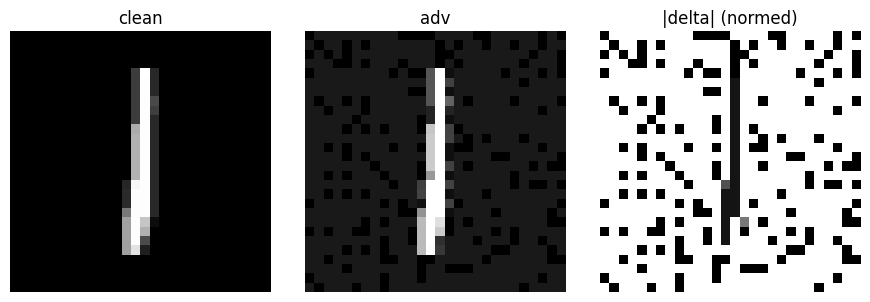

In [10]:
def _show(img, ax, title=''):
    x = np.asarray(img)
    # MNIST is (C,H,W) with C=1
    if x.ndim == 3 and x.shape[0] in {1,3}:
        x2 = np.transpose(x, (1,2,0))
        if x2.shape[2] == 1:
            x2 = x2[:,:,0]
    else:
        x2 = x
    ax.imshow(x2, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

i = 0
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
_show(bundle.X_test[i], axes[0], 'clean')
_show(X_adv_test[i], axes[1], 'adv')
delta = np.abs(X_adv_test[i] - bundle.X_test[i])
_show(delta / (delta.max() + 1e-12), axes[2], '|delta| (normed)')
plt.tight_layout()
plt.show()


### Subsample points for PH scoring (runtime control)

In [11]:
rng = np.random.default_rng(SEED)

def _subsample(X, y, n_max: int):
    X = np.asarray(X)
    y = np.asarray(y, dtype=int)
    if len(X) <= n_max:
        return X, y
    idx = rng.choice(np.arange(len(X)), size=int(n_max), replace=False)
    return X[idx], y[idx]

X_val_clean_used, y_val_clean_used = _subsample(bundle.X_val, bundle.y_val, MAX_POINTS_FOR_SCORING)
X_val_adv_used, y_val_adv_used = _subsample(X_adv_val, bundle.y_val, MAX_POINTS_FOR_SCORING)
X_test_clean_used, y_test_clean_used = _subsample(bundle.X_test, bundle.y_test, MAX_POINTS_FOR_SCORING)
X_test_adv_used, y_test_adv_used = _subsample(X_adv_test, bundle.y_test, MAX_POINTS_FOR_SCORING)

print('Val used:', X_val_clean_used.shape, X_val_adv_used.shape)
print('Test used:', X_test_clean_used.shape, X_test_adv_used.shape)


Val used: (150, 1, 28, 28) (150, 1, 28, 28)
Test used: (200, 1, 28, 28) (200, 1, 28, 28)


In [12]:
def _needs_y_pred(det_cfg: DetectorConfig) -> bool:
    if not bool(getattr(det_cfg, 'topo_class_conditional', False)):
        return False
    m = str(getattr(det_cfg, 'topo_class_scoring_mode', 'min_over_classes')).strip().lower()
    return m in {'predicted_class', 'pred', 'contrastive_pred_gap', 'contrastive', 'pred_gap'}


def run_variant(*, name: str, cfg: ExperimentConfig):
    t0 = time.perf_counter()

    scores_val_clean = compute_scores(X_val_clean_used, trained, bundle=bundle, cfg=cfg)
    scores_val_adv = compute_scores(X_val_adv_used, trained, bundle=bundle, cfg=cfg)
    scores_test_clean = compute_scores(X_test_clean_used, trained, bundle=bundle, cfg=cfg)
    scores_test_adv = compute_scores(X_test_adv_used, trained, bundle=bundle, cfg=cfg)

    scores_val_all = concat_scores(scores_val_clean, scores_val_adv)
    any_key = next(iter(scores_val_all.keys()))
    labels_val = np.concatenate([
        np.zeros(len(scores_val_clean[any_key]), dtype=int),
        np.ones(len(scores_val_adv[any_key]), dtype=int)
    ])
    y_val_all = np.concatenate([np.asarray(y_val_clean_used, dtype=int), np.asarray(y_val_adv_used, dtype=int)])

    y_pred_val_all = None
    if _needs_y_pred(cfg.detector):
        y_pred_val_clean = get_model_predictions(trained, np.asarray(X_val_clean_used), device=str(cfg.device), return_probs=False)
        y_pred_val_adv = get_model_predictions(trained, np.asarray(X_val_adv_used), device=str(cfg.device), return_probs=False)
        y_pred_val_all = np.concatenate([np.asarray(y_pred_val_clean, dtype=int), np.asarray(y_pred_val_adv, dtype=int)])

    detector = fit_detector(scores_val_all, labels_val, cfg, y_true=y_val_all, y_pred=y_pred_val_all)

    scores_test_all = concat_scores(scores_test_clean, scores_test_adv)
    any_key_t = next(iter(scores_test_all.keys()))
    labels_test = np.concatenate([
        np.zeros(len(scores_test_clean[any_key_t]), dtype=int),
        np.ones(len(scores_test_adv[any_key_t]), dtype=int)
    ])

    y_pred_test_all = None
    if _needs_y_pred(cfg.detector):
        y_pred_test_clean = get_model_predictions(trained, np.asarray(X_test_clean_used), device=str(cfg.device), return_probs=False)
        y_pred_test_adv = get_model_predictions(trained, np.asarray(X_test_adv_used), device=str(cfg.device), return_probs=False)
        y_pred_test_all = np.concatenate([np.asarray(y_pred_test_clean, dtype=int), np.asarray(y_pred_test_adv, dtype=int)])

    try:
        raw_scores_test = detector.score(scores_test_all, y_pred=y_pred_test_all)
    except TypeError:
        raw_scores_test = detector.score(scores_test_all)

    thr = float(getattr(detector, 'threshold', np.nan))
    metrics = evaluate_detector(np.asarray(labels_test, dtype=int), np.asarray(raw_scores_test, dtype=float), threshold=thr)
    wall = time.perf_counter() - t0

    return {
        'name': str(name),
        'cfg': cfg,
        'detector': detector,
        'scores_test_all': scores_test_all,
        'labels_test': labels_test,
        'raw_scores_test': np.asarray(raw_scores_test, dtype=float),
        'threshold': thr,
        'metrics': metrics,
        'wall_s': float(wall),
        'y_pred_test_all': y_pred_test_all,
    }


### Variants + run

In [13]:
variants = []
cfg_v0 = cfg_base
variants.append(('V0_pooled_global', cfg_v0))

cfg_v1 = replace(cfg_base, detector=replace(cfg_base.detector, topo_class_conditional=True, topo_class_scoring_mode='min_over_classes'))
variants.append(('V1_classcond_global', cfg_v1))

cfg_v2 = replace(cfg_v1, graph=replace(cfg_v1.graph, topo_neighbor_mode='class_pred'))
variants.append(('V2_classcond_classPredNbr', cfg_v2))

cfg_v3 = replace(cfg_v2, graph=replace(cfg_v2.graph, topo_metric_normalization='whiten', topo_whiten_ridge=1e-3))
variants.append(('V3_classPredNbr_whiten', cfg_v3))

cfg_v4 = replace(cfg_v3, detector=replace(cfg_v3.detector, topo_class_scoring_mode='contrastive_pred_gap'))
variants.append(('V4_contrastive_gap', cfg_v4))

results = []
for name, cfg in variants:
    print('Running', name)
    r = run_variant(name=name, cfg=cfg)
    results.append(r)
    m = r['metrics']
    print('  roc_auc=', m.get('roc_auc'), 'pr_auc=', m.get('pr_auc'), 'fpr@95=', m.get('fpr_at_tpr95'), 'wall_s=', r['wall_s'])

[(r['name'], float(r['metrics']['roc_auc'])) for r in results]


Running V0_pooled_global


KeyboardInterrupt: 

### ROC curves

In [ ]:
plt.figure(figsize=(6, 5))
for r in results:
    fpr = np.asarray(r['metrics']['fpr'])
    tpr = np.asarray(r['metrics']['tpr'])
    auc = float(r['metrics']['roc_auc'])
    plt.plot(fpr, tpr, label=f"{r['name']} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves (IMAGE: clean vs adversarial)')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()


### Score distributions

In [ ]:
ncols = 2
nrows = int(np.ceil(len(results) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4*nrows), squeeze=False)

for ax, r in zip(axes.ravel(), results):
    y = np.asarray(r['labels_test'], dtype=int)
    s = np.asarray(r['raw_scores_test'], dtype=float)
    thr = float(r['threshold'])
    ax.hist(s[y == 0], bins=40, alpha=0.6, label='clean', density=True)
    ax.hist(s[y == 1], bins=40, alpha=0.6, label='adv', density=True)
    ax.axvline(thr, color='k', linestyle='--', linewidth=1)
    ax.set_title(f"{r['name']}\nAUC={float(r['metrics']['roc_auc']):.3f}")
    ax.set_xlabel('detector score')
    ax.set_ylabel('density')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.2)

for ax in axes.ravel()[len(results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()
